In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Загрузка данных

Для начала загружаем таблицы с данными о завершенных курсах и оценках студентов на платформе онлайн-образования

In [2]:
def load_data_from_yandex_disk():
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # Ссылки на файлы
    urls = {
        'assessments': 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ',
        'courses': 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw',
        'studentAssessments': 'https://disk.yandex.ru/d/DYd4M5b_8RETsA',
        'studentRegistration': 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'
    }

    def get_csv_from_url(public_key):
        file_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(file_url)
        download_url = response.json()['href']
        return pd.read_csv(download_url)
    data = {}
    for key, url in urls.items():
        data[key] = get_csv_from_url(url)

    return data


data = load_data_from_yandex_disk()
assessments = data['assessments']
courses = data['courses']
studentAssessments = data['studentAssessments']
studentRegistration = data['studentRegistration']

### Описание данных

**assessments** — эта таблица содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен)

**courses** — таблица содержит список предметов по семестрам.

**studentAssessment** — эта таблица содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

**studentRegistration** — эта таблица содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

Посмотрим на содержание таблиц

In [3]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


**code_module** — идентификационный код предмета.

**code_presentation** — семестр (Идентификационный код).

**id_assessment** — тест (Идентификационный номер ассессмента).

**assessment_type** — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

**date** — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

**weight** — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [4]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


**code_module** — предмет (идентификационный код).

**code_presentation** — семестр (идентификационный код).

**module_presentation_length** — продолжительность семестра в днях.

In [5]:
studentAssessments.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


**id_assessment** — тест (идентификационный номер).

**id_student** — идентификационный номер студента.

**date_submitted** — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

**is_banked** — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

**score** — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [6]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


**code_module** — предмет (идентификационный код).

**code_presentation** — семестр (идентификационный код)

**id_student** — идентификационный номер студента.

**date_registration** — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

**date_unregistration** — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

### Предварительное исследование данных

Перед нами стоит задача проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. 

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  

6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для выполнения поставленных задач, необходимо определить, что явяется **курсом**.

Для этого обратимся снова к таблице **courses**

In [7]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Из таблицы видно, что одному коду предмета (code_module) соответствует несколько семестров (code_presentation), главным вопросом здесь будет - является ли уникальным курсом каждый уникальный код предмета (то есть AAA-2013J и AAA-2014J это один и тот же курс, но в разных семестрах), или же каждое сочитание является уникальным курсом? А может различия существуют между 2013J и 2013B)? Попробуем ответить на этот вопрос. 

Для начала посмотрим какие уникальные коды предметов существуют и какие семестры им соответствуют

In [8]:
uniq_code_module = courses.code_module.unique()
print("Уникальные коды предметов:", *uniq_code_module, end='\n\n')
for i in uniq_code_module:
    semesters = ', '.join(courses.query("code_module == @i").code_presentation.to_list())
    print(f'Семестры для модуля {i}: {semesters}')

Уникальные коды предметов: AAA BBB CCC DDD EEE FFF GGG

Семестры для модуля AAA: 2013J, 2014J
Семестры для модуля BBB: 2013J, 2014J, 2013B, 2014B
Семестры для модуля CCC: 2014J, 2014B
Семестры для модуля DDD: 2013J, 2014J, 2013B, 2014B
Семестры для модуля EEE: 2013J, 2014J, 2014B
Семестры для модуля FFF: 2013J, 2014J, 2013B, 2014B
Семестры для модуля GGG: 2013J, 2014J, 2014B


У нас есть 2013 и 2014 год, а также семестры J и B для каждого года. Для курсов пока не видно закономерности привязки к определенному семестру, поэтому скорее всегоналичие того или иного курса зависит от выбора его студентами.

Если предположение верно и курсы с одинаковыми кодами в разных семестрах это один и тот же курс, то не должно быть студентов, которые сдавали один и тот же курс в два разных семестра (за исключением получивших неудовлетворительную оценку или если курс был перезачтен). Проверим это предположение.

Будем считать курс завершенным для студента если есть информация о сданном экзамене, поэтому необходимо добавить информацию о коде предмета? семестре и типе теста из таблицы **assessments** к таблице  **studentAssessments**.

In [9]:
studentAssessments_mod = studentAssessments \
    .merge(assessments[['id_assessment', 'code_module', 'assessment_type', 'code_presentation']], on='id_assessment', how='left')
studentAssessments_mod.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation
0,1752,11391,18,0,78.0,AAA,TMA,2013J
1,1752,28400,22,0,70.0,AAA,TMA,2013J
2,1752,31604,17,0,72.0,AAA,TMA,2013J
3,1752,32885,26,0,69.0,AAA,TMA,2013J
4,1752,38053,19,0,79.0,AAA,TMA,2013J


Теперь проверим есть ли люди которые сдавали экзамен по предмету с одинаковым кодом более одного раза

In [10]:
stud_n_exams_by_module = studentAssessments_mod.query('assessment_type == "Exam"') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'id_assessment': "count"}) \
    .sort_values('id_assessment', ascending=False) \
    .rename(columns={'id_assessment': 'number_exams'}) 

stud_n_exams_by_module.head()

,id_student,code_module,number_exams
1569,540758,DDD,2
2587,593903,DDD,2
1444,527323,DDD,2
2859,605118,DDD,2
3298,626407,CCC,1


Есть 4 человека, которые сдавали один предмет дважды, посмотрим внимательно на информацию о них

In [11]:
id_stud_2exams = stud_n_exams_by_module.query('number_exams > 1').id_student
studentAssessments_mod.query('id_student.isin(@id_stud_2exams) and assessment_type == "Exam"') \
    .sort_values('id_student')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation
69928,25340,527323,229,0,24.0,DDD,Exam,2013B
87566,25361,527323,234,0,18.0,DDD,Exam,2014B
69983,25340,540758,229,0,40.0,DDD,Exam,2013B
87573,25361,540758,234,0,60.0,DDD,Exam,2014B
82731,25354,593903,241,0,49.0,DDD,Exam,2013J
95711,25368,593903,243,0,44.0,DDD,Exam,2014J
82844,25354,605118,237,0,42.0,DDD,Exam,2013J
95749,25368,605118,243,0,64.0,DDD,Exam,2014J


Все приведенные студенты сдавали экзамен по одному и тому же предмету с разницей в год. Первый студент провалил сдачу теста в первый раз (меньше 40 балловя), поэтому, возможно, это была пересдача. Остальные студенты имеют так же достаточно низкие баллы, близкие к проходному минимуму, поэтому возможно они решили пересдать предмет для получения лучших баллов.

Посмотрим сколько всего студентов сдавали экзамен по предмету DDD, чтобы понять какая доля сдавала его дважды, за одно посмотрим на количество сдач экзаменов на других курсах

In [12]:
studentAssessments_mod.query('assessment_type == "Exam"') \
    .groupby('code_module') \
    .agg({'id_student': 'nunique'}) \
    .rename(columns={'id_student': 'uniq_students'}) 

,uniq_students
code_module,
CCC,1915
DDD,3040


Получается, что экзамен студенты сдавали только по 2 курсам... Надо посмотреть, заложены ли экзамены в принципе в программу других курсов

Что касается доли сдававших повторно, то она достаточно мала, всего 4 человека из 3040

In [13]:
assessments.query('assessment_type == "Exam"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Для всех курсов присутствует экзамен для каждого семестра, что говорит о том, что экзамены по всем кроме двух предметов просто не были сданы. 

Для курса CCC их почему-то по 2 на каждый семестр. Посмотрим сколько человек проходили каждый из них, чтобы понять, что происходит

In [14]:
studentAssessments_mod \
    .query('code_module	 == "CCC" & assessment_type == "Exam"' ) \
    .groupby(['code_presentation', 'id_assessment'], as_index = False) \
    .agg({'id_student': 'nunique'}) \
    .rename(columns={'id_student': 'uniq_students'}) 

,code_presentation,id_assessment,uniq_students
0,2014B,24290,747
1,2014J,24299,1168


Студенты сдавали только один из экзаменов в семестре, поэтому, возможно, в данных об экзаменах какая-то ошибка.

Обобщим результаты: за исключением 4 студентов, которые, возможно, хотели пересдать экзамен, все сдавали экзамен по каждому из предметов только один раз, что может говорить о том, что курсы не отличаются в зависимости от семестра, а это все лишь разные потоки одного и того же курса. По этому за курс будем считать каждое уникальное значение кода курса, то есть AAA BBB CCC DDD EEE FFF GGG.


Теперь приступим к самим заданиям

### Задание 1

##### Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Воспользуемся модифицированной таблицей, чтобы это посчитать

Сначала отбираем экзамены с положительной оценкой, затем группируем по студенту и модулю, чтобы не упустить случаи, когда студент сдавал 2 раза один предмет, считаем количество экзаменов в каждом модуле для каждого студента и реструтктурируем таблицу, чтобы курсы оказались в столбцах, а затем создаем еще одну колонку one_course, в которой будет значение 1, если студент сдал только один курс и 0 - если два

In [15]:
t1 = studentAssessments_mod.query('assessment_type == "Exam" and score >= 40') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .pivot(index = 'id_student', columns = 'code_module', values = 'id_assessment') \
    .fillna(0)

t1 = t1.assign(one_course = t1.apply(lambda row: 1 if row['CCC'] == 0 or row['DDD'] == 0 else 0, axis=1))

t1.head()

code_module,CCC,DDD,one_course
id_student,,,
23698,1.0,0.0,1
24213,0.0,1.0,1
27116,1.0,0.0,1
28046,0.0,1.0,1
28787,1.0,0.0,1


Просуммировав столбец one_course получим количество студентов, успешно сдавших только один курс

In [16]:
t1.one_course.sum()

3805

### Задание 2

##### Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [17]:
studentAssessments_exams = studentAssessments_mod.query('assessment_type == "Exam"')
entAssessments_exams = studentAssessments_exams \
    .assign(success = studentAssessments_exams.score.apply(lambda x: "yes" if x >= 40 else "no"))
entAssessments_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation,success
52923,24290,558914,230,0,32.0,CCC,Exam,2014B,no
52924,24290,559706,234,0,78.0,CCC,Exam,2014B,yes
52925,24290,559770,230,0,54.0,CCC,Exam,2014B,yes
52926,24290,560114,230,0,64.0,CCC,Exam,2014B,yes
52927,24290,560311,234,0,100.0,CCC,Exam,2014B,yes


In [18]:
success_exams = entAssessments_exams.query('assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation', 'success'], as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .pivot(index =['code_module', 'code_presentation'], columns = 'success', values='id_assessment')
success_exams

success                         no   yes
code_module code_presentation           
CCC         2014B               83   664
            2014J              149  1019
DDD         2013B               98   504
            2013J               90   878
            2014B               39   485
            2014J              108   842

In [19]:
success_exams['completeness'] = round(success_exams.yes / (success_exams.no + success_exams.yes), 2) 
success_exams = success_exams.reset_index()
success_exams

success,code_module,code_presentation,no,yes,completeness
0,CCC,2014B,83,664,0.89
1,CCC,2014J,149,1019,0.87
2,DDD,2013B,98,504,0.84
3,DDD,2013J,90,878,0.91
4,DDD,2014B,39,485,0.93
5,DDD,2014J,108,842,0.89


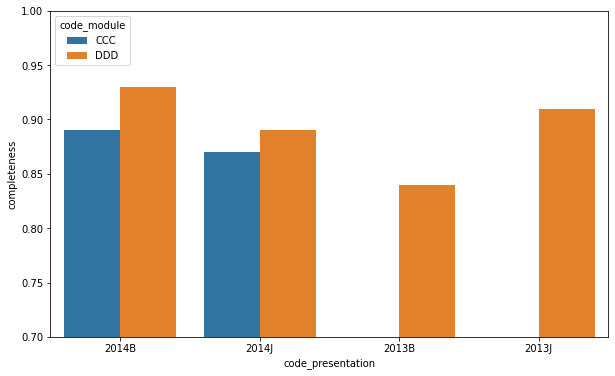

In [20]:
plt.figure(figsize=(10, 6))
plt.ylim(0.7, 1)
sns.barplot(data = success_exams, x = 'code_presentation', y = 'completeness', hue = 'code_module')

Как в рамках курса, так и в целом, самым сложным оказался экзамен на курсе DDD за семестр 2013B
Для курса CCC экзамен 2014J оказался сложее 2014B

Чтобы выявить какой курс сложнее, посчитаем среднее значение по всем экзаменам для каждого курса

In [21]:
success_exams.groupby('code_module').agg({'completeness': 'mean'})

,completeness
code_module,
CCC,0.8800
DDD,0.8925


Получается курс CCC сложнее

### Задание 3

##### По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

Так как каждый тест могут перезачесть, проверим, есть ли подозрительные значения (<= 0) в количестве прошедших дней с начала семестра

In [22]:
studentAssessments_mod.query('date_submitted <= 0 and assessment_type == "Exam"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation


Таих наблюдений нет

Из таблицы с экзаменами отберем даты (количество дней с начала семестра)успешных экзаменов и если их было больше одного,то только последнего

In [23]:
last_exams = entAssessments_exams.query('success == "yes"') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'date_submitted': 'max'})
last_exams.head()

,id_student,code_module,date_submitted
0,23698,CCC,243
1,24213,DDD,236
2,27116,CCC,243
3,28046,DDD,237
4,28787,CCC,243


In [24]:
last_exams.groupby('code_module').agg({'date_submitted': 'mean'}).round()

,date_submitted
code_module,
CCC,239.0
DDD,238.0


Для предмета CCC средний срок сдачи 239 дней, а для DDD	- 238

### Задание 4

##### Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 

#### Топ-3 предмета по популярности

In [25]:
studentRegistration.groupby('code_module') \
    .agg({'date_registration': 'count'}) \
    .sort_values('date_registration', ascending=False) \
    .head(3)

,date_registration
code_module,
BBB,7900
FFF,7751
DDD,6257


#### Топ-3 предмета по оттоку

In [26]:
studentRegistration.groupby('code_module') \
    .agg({'date_unregistration': 'count'}) \
    .sort_values('date_unregistration', ascending=False) \
    .head(3)

,date_unregistration
code_module,
FFF,2380
BBB,2377
DDD,2235


Самый большой отток получился у самых популярных курсов, но это логично, так как там изначально было больше людей, поэтому лучше посчитать долю выбавших студентов

In [27]:
module_reg = studentRegistration.groupby('code_module', as_index=False) \
    .agg({'date_registration': 'count', 'date_unregistration': 'count'})
module_reg = module_reg.assign(unreg_pers = round(module_reg.date_unregistration / module_reg.date_registration * 100, 2))
module_reg

,code_module,date_registration,date_unregistration,unreg_pers
0,AAA,748,126,16.84
1,BBB,7900,2377,30.09
2,CCC,4426,1947,43.99
3,DDD,6257,2235,35.72
4,EEE,2932,718,24.49
5,FFF,7751,2380,30.71
6,GGG,2534,289,11.40


Теперь выведем топ-3

In [28]:
module_reg[['code_module', 'unreg_pers']] \
    .sort_values('unreg_pers', ascending=False) \
    .head(3)

,code_module,unreg_pers
2,CCC,43.99
3,DDD,35.72
5,FFF,30.71


Таким образом, самыми популярными курсами являются FFF, BBB, DDD.

А самый высокий отток у CCC, DDD и FFF, при чем с курса CCC уходят аж 44% студентов.

### Задание 5

##### Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Возьмем таблицу с созданным на прошлых шагах столбцом success, обозначающим удачу или неудачу на экзамене

In [29]:
entAssessments_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,code_presentation,success
52923,24290,558914,230,0,32.0,CCC,Exam,2014B,no
52924,24290,559706,234,0,78.0,CCC,Exam,2014B,yes
52925,24290,559770,230,0,54.0,CCC,Exam,2014B,yes
52926,24290,560114,230,0,64.0,CCC,Exam,2014B,yes
52927,24290,560311,234,0,100.0,CCC,Exam,2014B,yes


Теперь посчитаем завершаемость для каждого семестра

In [30]:
success_exams = entAssessments_exams.query('assessment_type == "Exam"') \
    .groupby(['code_presentation', 'success'], as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .pivot(index ='code_presentation', columns = 'success', values='id_assessment')
success_exams['completeness'] = round(success_exams.yes / (success_exams.no + success_exams.yes), 2) 
success_exams

success,no,yes,completeness
code_presentation,,,
2013B,98,504,0.84
2013J,90,878,0.91
2014B,122,1149,0.90
2014J,257,1861,0.88


Семестр с самой низкой завершаемостью - 2013B

Теперь посмотрим на средние сроки сдачи курсов (будем подразумевать под сдачей курса успешную сдачу экзамена), будем рассматривать опять только успешные последние попытки

In [31]:
entAssessments_exams.query('success == "yes"') \
    .groupby(['id_student', 'code_presentation'], as_index=False) \
    .agg({'date_submitted': 'max'}) \
    .groupby('code_presentation') \
    .agg({'date_submitted': "mean"}) \
    .round()

,date_submitted
code_presentation,
2013B,230.0
2013J,240.0
2014B,233.0
2014J,244.0


семестр с самым долгим средним сроком сдачи курса - 2014J

### Задание 6

##### Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для начала необходимо рассчитать метрики RFM (Recency, Frequency, Monetary), в нашем случае это будут:

1. R - среднее время сдачи одного экзамена;
2. F - завершаемость курсов;
3. M - среднее количество баллов, получаемое за экзамен.

Начнем со среднего времени сдачи экзамена, будем учитывать только успешные попытки

In [32]:
rfm = entAssessments_exams.query('success == "yes"') \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns={'date_submitted': 'R'})
rfm.head()

,id_student,R
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0


Теперь рассчитаем завершаемость курсов для каждого студента.

Будем считать завершаемость как количество отношение завершенных курсов (успешно сдан экзамен) ко всем курсам, на которые был зарегистрирован студент

Чтобы посчитать количество сданных экзаменов возьмем таблицу last_exams с прошлых шагов, так как в ней учтена только последняя попытка, если было более одной успешной сдачи жкзамена

In [33]:
suc_exams = last_exams \
    .groupby('id_student', as_index=False) \
    .agg({'code_module': 'count'}) \
    .rename(columns={'code_module': 'exams'}) 
suc_exams.head()

,id_student,exams
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1


Теперь посчитаем на какое количество курсов регистрировался каждый студент

Сначала группируем по id и code_module, а затем еще раз по id, чтобы избежать повторное засчитывание одного и того же курса 

In [34]:
reg = studentRegistration \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'date_registration': 'count'}) \
    .rename(columns={'date_registration': 'courses'}) \
    .groupby('id_student', as_index=False) \
    .agg({'courses': 'count'})
reg.head()

,id_student,courses
0,3733,1
1,6516,1
2,8462,1
3,11391,1
4,23629,1


Соединяем таблицы и вычисляем метрику

In [35]:
completeness = suc_exams.merge(reg, on='id_student', how='outer').fillna(0)
completeness['F'] = completeness.exams / completeness.courses
completeness.head()

,id_student,exams,courses,F
0,23698,1.0,1,1.0
1,24213,1.0,1,1.0
2,27116,1.0,1,1.0
3,28046,1.0,1,1.0
4,28787,1.0,1,1.0


Теперь добавляем метрику в основную таблицу

In [36]:
rfm = rfm.merge(completeness[['id_student', 'F']], on='id_student')
rfm.head()

,id_student,R,F
0,23698,243.0,1.0
1,24213,236.0,1.0
2,27116,243.0,1.0
3,28046,237.0,1.0
4,28787,243.0,1.0


Рассчитаем среднее количество баллов, получаемое за экзамен

Тут для полной картины будем считать все попытки экзаменов

In [37]:
score = studentAssessments_exams \
    .groupby('id_student', as_index=False) \
    .agg({'score': 'mean'}) \
    .rename(columns={'score': 'M'})
rfm = rfm.merge(score, on='id_student')
rfm.head()

,id_student,R,F,M
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


Теперь посмотрим на описательные статистики, чтобы понять как варьируются переменные и определить на сколько групп надо разделить каждую метрику

In [38]:
rfm.describe()

,id_student,R,F,M
count,4.097000e+03,4097.000000,4097.000000,4097.000000
mean,7.382490e+05,238.466317,0.912660,69.639370
std,5.858543e+05,5.632457,0.190049,17.050648
min,2.369800e+04,229.000000,0.333333,32.000000
25%,5.044290e+05,234.000000,1.000000,56.000000
50%,5.920930e+05,241.000000,1.000000,69.000000
75%,6.488410e+05,243.000000,1.000000,84.000000
max,2.698251e+06,285.000000,1.000000,100.000000


Значения F ограничены из-за небольшого количества курсов, поэтому посмотрим какие существуют варианты 

In [39]:
rfm.F.unique()

array([1.        , 0.5       , 0.33333333, 0.66666667])

Скорость прохождения курса разобьем на 3 равных интервала, завершаемость тоже на 3, но со значениями от 0 до 0.5 (половина курсов), от 0.5 до 0.7 (почти все) и 0.7 до 1 - все. Оценки на 3 интервала - меньше 40 баллов (не сдавшие), от 40 до 70 (средняя оценка), от 70 до 100 (отличная оценка).

In [40]:
rfm['R_score'] = pd.cut(rfm['R'], bins = 3, labels = [3,2,1])
rfm['F_score'] = pd.cut(rfm['F'], bins = [0, 0.5, 0.7, 1], labels = [1,2,3])
rfm['M_score'] = pd.cut(rfm['M'], bins = [0,39,70,101], labels = [1,2,3])

In [41]:
rfm.head()

,id_student,R,F,M,R_score,F_score,M_score
0,23698,243.0,1.0,80.0,3,3,3
1,24213,236.0,1.0,58.0,3,3,2
2,27116,243.0,1.0,96.0,3,3,3
3,28046,237.0,1.0,40.0,3,3,2
4,28787,243.0,1.0,44.0,3,3,2


Соединим оценки в сегменты

In [42]:
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()

,id_student,R,F,M,R_score,F_score,M_score,RFM_score
0,23698,243.0,1.0,80.0,3,3,3,333
1,24213,236.0,1.0,58.0,3,3,2,332
2,27116,243.0,1.0,96.0,3,3,3,333
3,28046,237.0,1.0,40.0,3,3,2,332
4,28787,243.0,1.0,44.0,3,3,2,332


Теперь выделим наиболее интересные кластеры 

111, 211, 311 - двоечники - студенты не завершившие ни одного курса

333 - чемпионы - все курса завершены, максимальный балл и скорость 

122, 222, 322 - среднечки - колчичество баллов выше порога, но несильно, курсов завершено больше половины, но не все 

132, 232, 332 - проходные - сдали все экзамены с не очень высокими баллами

133, 233 - отстающие - сдали все экзамены отлично, но с низкой или средней скоростью

112 - на волоске - сдали меньше половины экзаменов, медленно, на небольшие баллы

In [43]:
def name_clusters(x):
    two = ['111', '211', '311']
    champion = ['333']
    middle = ['222', '122', '322']
    passing = ['132', '232', '332']
    lagging = ['133', '233']
    thread = ['112']
    if x in two:
        return 'двоечники'
    elif x in champion:
        return 'чемпионы'
    elif x in middle:
        return 'среднечки'
    elif x in passing:
        return 'проходные'
    elif x in lagging:
        return 'отстающие'
    elif x in thread:
        return 'на волоске'
    else:
        return 'остальные'

In [44]:
rfm['cluster'] = rfm.RFM_score.apply(name_clusters)
rfm.head()

,id_student,R,F,M,R_score,F_score,M_score,RFM_score,cluster
0,23698,243.0,1.0,80.0,3,3,3,333,чемпионы
1,24213,236.0,1.0,58.0,3,3,2,332,проходные
2,27116,243.0,1.0,96.0,3,3,3,333,чемпионы
3,28046,237.0,1.0,40.0,3,3,2,332,проходные
4,28787,243.0,1.0,44.0,3,3,2,332,проходные


Посмотрим распространенность кластеров в данных (в процентах)

In [45]:
clusters = rfm.groupby('cluster', as_index=False).agg({'id_student': 'count'})
clusters['pers'] = clusters.id_student / clusters.id_student.sum() * 100
clusters

,cluster,id_student,pers
0,двоечники,7,0.170857
1,на волоске,1,0.024408
2,остальные,707,17.256529
3,отстающие,29,0.707835
4,проходные,1725,42.103979
5,чемпионы,1628,39.736392


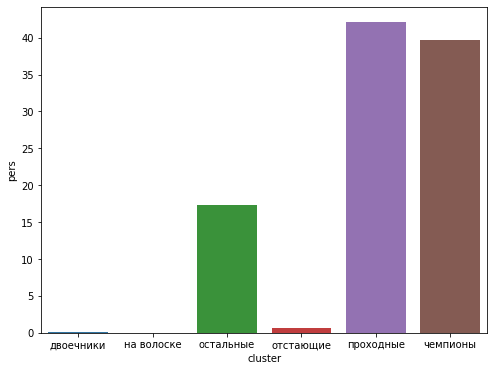

In [46]:
plt.figure(figsize=(8, 6))
sns.barplot(data=clusters, x='cluster', y='pers')

Основная масса - это чемпионы и проходные - суммарно больше 80% учеников. Двоечников и тех кто на волоске крайне мало - меньше процента. Среднечков вообще не оказалось. В целом, видим достаточно хорошую успеваемость, большая часть студентов, видимо, заинтересована в обучении.